<a href="https://colab.research.google.com/github/aquapathos/openCVLesson/blob/master/IP/dither.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像表示のための画像処理

## 課題概要
　「ディザ変換」と「誤差拡散法」を実際の画像に適用し、その性質を理解する。

  　少なくとも１つ以上の対象画像に対し、次の５つの画像変換を実行し、その結果を比較考察せよ。  
  (a)  Bayer 型４x４ディザマトリクスを用いたディザ変換  
  (b) 自分で設計した４x４ディザマトリクスを用いたディザ変換   
  (c) ランダムディザ変換（画素ごとに乱数でしきい値を定めて２値化する方法）  
  (d) ４x４のブロック化ランダムディザ変換（４x４の区画ごとにランダムにディザマトリクスを発生してディザ変換する方法）  
  (e)  誤差拡散法
  
##  注意事項
1. 処理内容を理解して適切な画像を処理対象に選ぶこと。細かく濃淡が変化するような画像は対象として適さない。濃淡がなさすぎる画像も適さない。

2.   ディザマトリクスは４行４列の行列、つまり16個の数値で定義される。この16個は０〜１５を重複なく１度ずつ使用するのが原則である。  
考察実験として原則を守らなかった場合にどうなるかを試すのは構わないが，守った場合を報告した上での追加実験として実施すること．
3. 必ず原画と結果画像を示すのは当然であり、加えて、(a)(b)では使用したマトリクスを示すこと。
4. 感想は不要。見た目どうであるという観察結果を述べるだけでは考察とは言えない．必ずそれぞれのアルゴリズムや理論と関連づけて結果を評価せよ．


## 参考 URL
- [ディザリング(パターン・ディザ)](http://koujinz.cocolog-nifty.com/blog/2009/04/post-ebdd.html)
-[誤差拡散法](http://koujinz.cocolog-nifty.com/blog/2009/04/post-a316.html)

# 1.  画像のアップロードと読み込み
## 処理対象画像についての注意

- 注意事項１を念頭に入れて、対象画像を選ぶこと。
 
- 下のプログラムでは、実験条件を均一にするために、処理対象画像の中央を正方形にクリッピングし、256x256のサイズにリサイズする。それを念頭に入れて画像を選ぶこと。観察したい部分が上下左右にずれているなら、それが中央に来るように自分で切り抜いた画像をアップせよ。
 
-  カラー画像を対象としたディザ変換、誤差拡散も可能であるが、ここではグレイ画像を実験対象としている。読み込み時にグレイで読み込むので、事前にグレイ画像に変換する必要はない。
 

# 単純な２階調化

比較のために、単純な２階調化結果を示しておく。ここでは大津の方法（判別分析法）を用いてしきい値を決定した。

ディザ変換も誤差拡散法も結果画像は２値画像であるということに注意されたい。

In [1]:
import urllib.request
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files

# 実行処理対象画像の入力

次のセルの実行時に、以下の３つの方法のいずれかで処理対象画像を入力する。

1. 即時アップロード  （セル実行時に画像をアップロード。ファイル名は入力不要）2. 事前アップロード　（事前にファイルをアップロード。そのファイル名を入力）
3. URL指定　　（画像に直リンクされた urlと、その画像につける任意のファイル名を入力）

Memo
url="https://bit.ly/2UV9wI2" # Lena

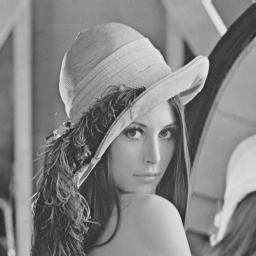

図１. 処理対象画像（グレイ変換と２５６x２５６サイズにリサイズ済


In [2]:
# 処理対象画像の指定
画像入力方法 = "URL\u6307\u5B9A"  #@param ["即時アップロード","事前アップロード", "URL指定"]
url="https://bit.ly/2UV9wI2" #@param {type:"string"}
ファイル名を入力してください="rad.png" #@param {type:"string"}
if 画像入力方法 == "即時アップロード":
  filename = list(files.upload())[0]
  img = cv2.imread(filename,0) # グレイモードで読み込み
elif 画像入力方法 == "事前アップロード":
  filename = ファイル名を入力してください
  img = cv2.imread(filename,0) # グレイモードで読み込み
else: # URLからのダウンロード
  img_path, header = urllib.request.urlretrieve(url)
  img = cv2.imread(img_path,0)  # グレイモードで読み込み
  filename = ファイル名を入力してください

(height,width) = img.shape[:2]
size = height if height < width else width
img = img[(height-size)//2:(height-size)//2+size,(width-size)//2:(width-size)//2+size]
img = cv2.resize(img,(256,256))
cv2_imshow(img)
cv2.imwrite("fig1.png",img)
print("図１. 処理対象画像（グレイ変換と２５６x２５６サイズにリサイズ済")

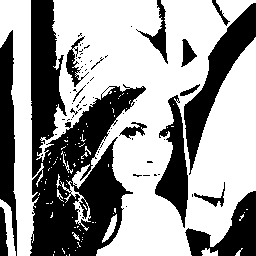

図２.  単純な２階調化結果（しきい値=124.0）


In [3]:
ret, otsu = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cv2_imshow(otsu)
cv2.imwrite("fig2.png",otsu)
print("図２.  単純な２階調化結果（しきい値={}）".format(ret))

# (a) Bayer 型４x４ディザマトリクスを用いたディザ変換
![BayerMatrix](https://user-images.githubusercontent.com/5820803/60696511-9f56cf80-9ed5-11e9-9000-4f43fbdfdfd5.png)

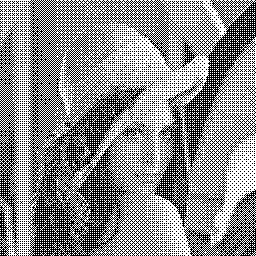

図3.  ディザ変換結果（Bayer型４x４ディザマトリクスを使用）


In [4]:
gray = img.copy()

# ディザマトリクス
matrix = [[0, 8, 2, 10],[12, 4, 14, 6], [3, 11, 1, 9], [15, 7, 13, 5]]

# 0〜255に変換
gray = gray // 16
 
for i in range(256):
	for j in range(256):
		if gray[i][j] < matrix[i % 4][j % 4]: # 4区切りずつ判定する
			gray[i][j] = 0
		else:
			gray[i][j] = 255
cv2_imshow(gray)
cv2.imwrite("fig3.png",gray)
print("図3.  ディザ変換結果（Bayer型４x４ディザマトリクスを使用）")

# (b) 自分で設計した４x４ディザマトリクスを用いたディザ変換

In [5]:
# 自作ディザマトリクス   (0~15をもれなく使う)
matrix = [[0, 1, 2, 3],[4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15]]

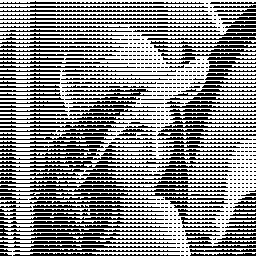

図4.  ディザ変換結果（オリジナルのディザマトリクス


In [6]:
gray = img.copy()

# 0〜15に変換
gray = gray // 16
 
for i in range(256):
	for j in range(256):
		if gray[i][j] < matrix[i % 4][j % 4]: # 4区切りずつ判定する
			gray[i][j] = 0
		else:
			gray[i][j] = 255
 
cv2_imshow(gray)
cv2.imwrite("fig4.png",gray)
print("図4.  ディザ変換結果（オリジナルのディザマトリクス")


# (c) ランダムディザ変換（画素ごとに乱数でしきい値を定めて２値化する方法）

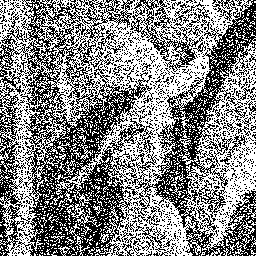

図５.  画素ごとのランダムディザ変換の結果


In [7]:
import random
gray = img.copy()
 
for i in range(256):
	for j in range(256):
		 gray[i][j] = 0  if gray[i][j] < random.randint(0, 255) else 255
 
cv2_imshow(gray)
cv2.imwrite("fig5.png",gray)
print("図５.  画素ごとのランダムディザ変換の結果")


# (c) ブロック化ランダムディザ変換

###  4 x 4 ブロック

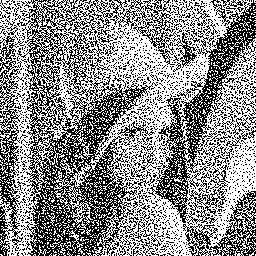

図６.  ブロック化ランダムディザ変換（４x４）


In [8]:
BLOCKSIZE = 4
CELLS = BLOCKSIZE*BLOCKSIZE
gray = img.copy() //(256//CELLS)

for i in range(256//BLOCKSIZE):
    for j in range(256//BLOCKSIZE): 
        # ランダムなディザマトリクスの生成
        nums = np.arange(CELLS).tolist()
        random.shuffle(nums) # シャッフルする
        matrix = np.array(nums).reshape(BLOCKSIZE,BLOCKSIZE)
        for s in range(BLOCKSIZE):
            for t in range(BLOCKSIZE):
                gray[i*BLOCKSIZE+s,j*BLOCKSIZE+t] = 0 if gray[i*BLOCKSIZE+s,j*BLOCKSIZE+t] < matrix[s,t]  else 255 
        
cv2_imshow(gray)
cv2.imwrite("fig6.png",gray)
print("図６.  ブロック化ランダムディザ変換（４x４）")

### 参考　２x２ブロック

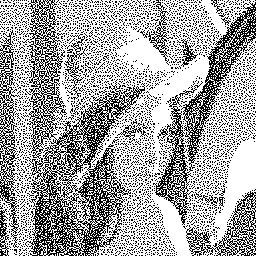

図６-2.  ブロック化ランダムディザ変換（２x２）


In [9]:
BLOCKSIZE = 2
CELLS = BLOCKSIZE*BLOCKSIZE
gray = img.copy() //(256//CELLS)

for i in range(256//BLOCKSIZE):
    for j in range(256//BLOCKSIZE): 
        # ランダムなディザマトリクスの生成
        nums = np.arange(CELLS).tolist()
        random.shuffle(nums) # シャッフルする
        matrix = np.array(nums).reshape(BLOCKSIZE,BLOCKSIZE)
        for s in range(BLOCKSIZE):
            for t in range(BLOCKSIZE):
                gray[i*BLOCKSIZE+s,j*BLOCKSIZE+t] = 0 if gray[i*BLOCKSIZE+s,j*BLOCKSIZE+t] < matrix[s,t]  else 255 
        
cv2_imshow(gray)
cv2.imwrite("fig6-2.png",gray)
print("図６-2.  ブロック化ランダムディザ変換（２x２）")

# (e) 誤差拡散法

## e-1 誤差拡散法１　単純右送り
授業では誤差を右、左下、下、右下に分配したが、ここではより基本的な、右隣りの画素にのみ誤差を順送りする方法を試してみよう。

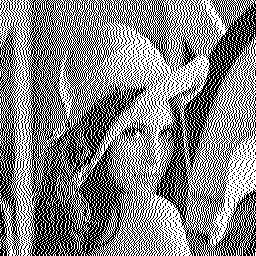

図７-1.  単純右送りの誤差拡散法の結果


In [10]:
gray = img.copy()

thresh = 128 # 閾値
err = 0 # 誤差
 
for i in range(256):
	for j in range(256):
		if gray[i][j] + err < thresh:
			err = gray[i][j] + err - 0 # 誤差を計算
			gray[i][j] = 0
		else:
			err = gray[i][j] + err - 255 # 誤差を計算
			gray[i][j] = 255
            
cv2_imshow(gray)
cv2.imwrite("fig7.png",gray)
print("図７-1.  単純右送りの誤差拡散法の結果")

## e-1 誤差拡散法２　誤差を4方向分配する方法
次のプログラムは授業で説明した、量子化誤差を４方向に分配して転嫁する方法である。誤差は右と下に１６分の５ずつ、右下と左下にそれぞれ１６分の３分配される。

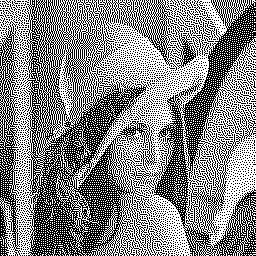

図７-2.  隣接４画素への誤差拡散の結果


In [11]:
gray = img.copy().astype(np.float32)

thresh = 128 # 閾値
err = 0 # 誤差
 
for i in range(256):
	for j in range(256):
            if gray[i][j]< thresh:
                err = gray[i][j] # 誤差を計算
                gray[i][j] = 0
            else:
                err = gray[i][j] - 255 # 誤差を計算
                gray[i][j] = 255
                        
            if i < 255 : 
                if  j < 255:
                    gray[i][j+1] += (5.0/16)*err        #  右
                    gray[i+1][j -1] += (3.0/16)*err   #  左下
                    gray[i+1][j] += (5.0/16)*err        #  下
                    gray[i+1][j +1] += (3.0/16)*err  #  右下 
                else:   # 右端で一番下の行以外
                    gray[i+1][j-1] += (5.0/8)*err    #   左下
                    gray[i+1][j] += (5.0/8)*err        #  下
            elif  j != 255 : # 一番下の行の場合は右奥りのみ 
                gray[i][j+1] += err
            
cv2_imshow(gray)
print("図７-2.  隣接４画素への誤差拡散の結果")

# 別の画像での実験
別の画像で実験する場合は、結果画像を保存後上からやり直すか、この下にプログラムを上からコピー＆ペーストして実行してください。

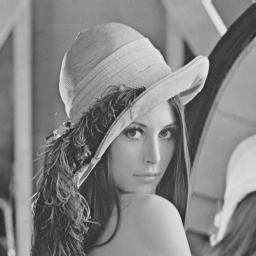

図８. 処理対象画像（グレイ変換と２５６x２５６サイズにリサイズ済


In [13]:
# 処理対象画像の指定
画像入力方法 = "URL\u6307\u5B9A"  #@param ["即時アップロード","事前アップロード", "URL指定"]
url="https://bit.ly/2UV9wI2" #@param {type:"string"}
ファイル名を入力してください="rad.png" #@param {type:"string"}
if 画像入力方法 == "即時アップロード":
  filename = list(files.upload())[0]
  img = cv2.imread(filename,0) # グレイモードで読み込み
elif 画像入力方法 == "事前アップロード":
  filename = ファイル名を入力してください
  img = cv2.imread(filename,0) # グレイモードで読み込み
else: # URLからのダウンロード
  img_path, header = urllib.request.urlretrieve(url)
  img = cv2.imread(img_path,0)  # グレイモードで読み込み
  filename = ファイル名を入力してください

(height,width) = img.shape[:2]
size = height if height < width else width
img = img[(height-size)//2:(height-size)//2+size,(width-size)//2:(width-size)//2+size]
img = cv2.resize(img,(256,256))
cv2_imshow(img)
cv2.imwrite("fig8.png",gray)
print("図８. 処理対象画像（グレイ変換と２５６x２５６サイズにリサイズ済")